# Camino más corto
### Tarea entrevista técnica Inventures

## Import Libraries

In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas
from geopy.distance import geodesic

# grafos
import networkx as nx

## Read Data

In [114]:
# import csv
df_car_gps = pd.read_csv('vehicle_gps.csv')
df_car_gps

,vehicle,latitude,longitude,timestamp
0,A,-33.416709,-70.592693,01-01-2022 8:01:00
1,A,-33.417425,-70.592487,01-01-2022 8:02:26
2,A,-33.417831,-70.592367,01-01-2022 8:04:09
3,A,-33.417879,-70.592018,01-01-2022 8:05:34
4,A,-33.417818,-70.591653,01-01-2022 8:07:26
5,A,-33.417763,-70.591365,01-01-2022 8:09:14
6,A,-33.417742,-70.591373,01-01-2022 8:11:10
7,A,-33.417691,-70.591139,01-01-2022 8:12:49
8,A,-33.417616,-70.590700,01-01-2022 8:13:54
9,A,-33.417424,-70.589862,01-01-2022 8:14:02


## Data Cleaning

### Handle duplicates

In [115]:
# Function that calculates distance between two coordinates
# Result in meters
def haversine(lat1, lon1, lat2, lon2, to_radians=True, earth_radius=6371):
    if to_radians:
        lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    a = np.sin((lat2-lat1)/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    return earth_radius * 2 * np.arcsin(np.sqrt(a)) * 1000

In [120]:
# create nodes dataframe
df_car_nodes = df_car_gps

# format timestamp to datetime type
df_car_nodes['timestamp'] = pd.to_datetime(df_car_nodes['timestamp'])

df_car_nodes = df_car_nodes[['latitude', 'longitude', 'timestamp', 'vehicle']]

# join nodes closer than 20 meters apart
common = []
for idx1, row1 in enumerate(df_car_nodes[['latitude', 'longitude']].values.tolist()):
    for idx2, row2 in enumerate(df_car_nodes[['latitude', 'longitude']].values.tolist()[idx1 + 1:]):
        if (haversine(row1[0], row1[1], row2[0], row2[1]) < 20):
            common.append([row1[0], row1[1], row2[0], row2[1]])

for lat_long in common:
    df_car_nodes.loc[df_car_nodes['latitude'] == lat_long[2], ['latitude']] = lat_long[0]
    df_car_nodes.loc[df_car_nodes['longitude'] == lat_long[3], ['longitude']] = lat_long[1]

# handle duplicates
# duplicate locations or timestamps will only be deleted if they're consecutive
df_car_nodes = df_car_nodes[(df_car_nodes[['latitude', 'longitude']].ne(df_car_nodes[['latitude', 'longitude']].shift())).any(axis=1)]
df_car_nodes = df_car_nodes[(df_car_nodes[['timestamp']].ne(df_car_nodes[['timestamp']].shift())).any(axis=1)].reset_index(drop=True)

# create new dataframe with Graph edges
df_car_edges = df_car_nodes

# concat latitude and longitude columns and save it as a starting point
df_car_edges['source'] = df_car_edges['latitude'].astype(str) + ', ' + df_car_edges['longitude'].astype(str)

# create new column containing each row's 'next row' consisting as ending point
df_car_edges['target'] = df_car_edges.groupby('vehicle')['source'].shift(-1)

# create new column containing the amount of time between starting and ending point
df_car_edges['time'] = df_car_edges['timestamp'].diff().dt.total_seconds().shift(-1)

df_car_edges = df_car_edges[['source', 'target', 'time', 'vehicle']]
df_car_edges = df_car_edges.dropna().reset_index(drop=True)
df_car_edges

,source,target,time,vehicle
0,"-33.416709, -70.592693","-33.417425, -70.592487",86.0,A
1,"-33.417425, -70.592487","-33.417831, -70.592367",103.0,A
2,"-33.417831, -70.592367","-33.417879, -70.592018",85.0,A
3,"-33.417879, -70.592018","-33.417818, -70.591653",112.0,A
4,"-33.417818, -70.591653","-33.417763, -70.591365",108.0,A
5,"-33.417763, -70.591365","-33.417691, -70.591139",215.0,A
6,"-33.417691, -70.591139","-33.417616, -70.5907",65.0,A
7,"-33.417616, -70.5907","-33.417424, -70.589862",8.0,A
8,"-33.417424, -70.589862","-33.417304, -70.589254",59.0,A
9,"-33.417304, -70.589254","-33.417633, -70.589041",97.0,A


## Weighted Graph

#### Generate nodes and edges with time as weight. Edge colors represent different cars.

In [122]:
# Generate graph from edge dataframe
G = nx.from_pandas_edgelist(df_car_edges, source='source', target='target', edge_attr=['time', 'vehicle'])

In [123]:
# Function that compares lat/long to the nodes in the Graph and returns
# its location if its closer than 20 meters apart
def close_node(lat, long, m):
    for idx, row in enumerate(df_car_nodes[['latitude', 'longitude']].values.tolist()):
        if (haversine(row[0], row[1], lat, long) < m):
            return (row[0], row[1])

In [154]:
# Function that calculates the shortest path a car can take from
# lat_i/long_i to lat_f/long_f using Graphs
def shortest_path(graph, lat_i, long_i, lat_f, long_f):
    
    lat_a = lat_i
    long_a = long_i
    lat_b = lat_f
    long_b = long_f
    
    # if the starting point is not in the graph, check if there is a node with a location
    # less than 20 meters away
    if (str(lat_i) +', ' + str(long_i) not in df_car_edges.source.values):
        close = close_node(lat_i, long_i, 20)
        lat_a = close[0]
        long_a = close[1]
    
    # same for the ending point
    if (str(lat_f) +', ' + str(long_f) not in df_car_edges.source.values):
        close = close_node(lat_f, long_f, 20)
        lat_b = close[0]
        long_b = close[1]
    
    # Shortest path from source to target.
    path = nx.shortest_path(graph, source=str(lat_a) + ', '+ str(long_a), target=str(lat_b) + ', '+ str(long_b), weight="time")

    # Shortest time from source to target
    time = nx.shortest_path_length(graph, source=str(lat_a) + ', '+ str(long_a), target=str(lat_b) + ', '+ str(long_b), weight="time")
    print('El camino más corto demora ' + str(time) + ' segundos')

    # separate edges according to each car
    e_a = [(u, v) for (u, v, d) in G.edges(data=True) if d.get('vehicle') == 'A']
    e_b = [(u, v) for (u, v, d) in G.edges(data=True) if d.get('vehicle') == 'B']
    e_c = [(u, v) for (u, v, d) in G.edges(data=True) if d.get('vehicle') == 'C']

    # positions for all nodes - seed for reproducibility
    pos = nx.spring_layout(G, seed=7)

    # nodes
    nx.draw_networkx_nodes(G, pos, node_size=150, node_color='black')

    # edges
    nx.draw_networkx_edges(G, pos, width=1, edgelist=e_a, edge_color='b', label='A')
    nx.draw_networkx_edges(G, pos, width=1, edgelist=e_b, edge_color='r', label='B')
    nx.draw_networkx_edges(G, pos, width=1, edgelist=e_c, edge_color='g', label='C')

    # shortest path nodes coloured in grey
    nx.draw_networkx_nodes(G, pos, node_size=150, nodelist=path, node_color='grey')

    # node labels
    labels = {}  
    labels[str(lat_a) + ', ' + str(long_a)] = 'I'
    labels[str(lat_b) + ', ' + str(long_b)] = 'F'
    nx.draw_networkx_labels(G,pos,labels,font_size=16,font_color='black')
    #nx.draw_networkx_labels(G, pos, font_size=5, font_family="sans-serif")

    # edge weight labels
    edge_labels = nx.get_edge_attributes(G, "time")
    nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=1)

    ax = plt.gca()
    ax.legend()
    ax.margins(0.01)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

El camino más corto demora 976.0 segundos


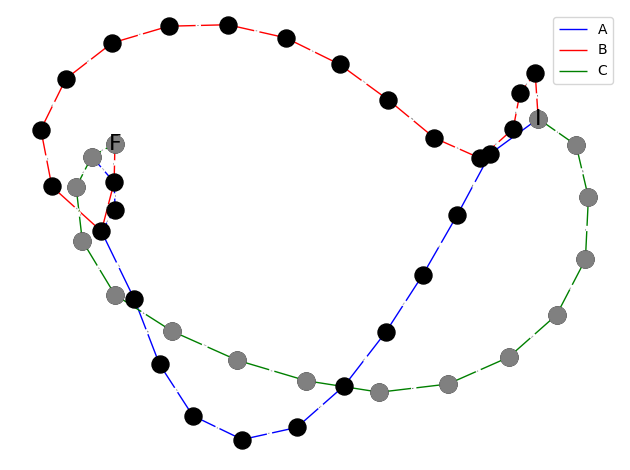

In [155]:
shortest_path(G, -33.416709,-70.592693, -33.417523,-70.58739)